## Final Project Submission

Please fill out:
* Student name: Fernando Aguilar Islas
* Student pace: Part Time
* Scheduled project review date/time: Tuesday, April 16, 2019 - 12:00 EST
* Instructor name: Brandon Lewis
* Blog post URL: https://medium.com/@feraguilari/multiple-regression-and-recursive-feature-elimination-rfe-34af0c6ae51b?source=friends_link&sk=f641e13e19195d3f673616b252c06b75

# King's County Data Set

For this project, I will create a multi-factor model using housing features contained in the King's County data set to predict house prices. Throughout the project, I will be using the OSEMN model consisting of the following steps: Obtain, Scrub, Explore, Model, and iNterpret the data. The information given for the data set features the following:

### Column Names and descriptions
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## 1. Obtain
The main objective of this project is to derive a multi-factor model that predicts housing prices as accurately as possible, using relevant features only.
I will start by importing the necessary libraries and obtaining the data from the file 'kc_house_data.csv' to start my Exploratory and Data Analysis (EDA).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mas
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


* The dataframe contains 21 columns and 21,597 rows. From this information, I can see that the following variables have null values: waterfront, view, and yr_renovated.
* Also, there are some variables with the incorrect datatype. I will address this issue after exploring the data and determining their correct datatype and change accordingly.
* Price is the target variable, leaving 20 features to construct the model.<br>

To start exploring the data I am going to visualize the first rows of the dataframe to see a sample of the values cointained in them. I will split them in two to be able to visualize all columns.

In [3]:
df.iloc[:5,:10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0


In [4]:
df.iloc[:5,10:]

,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## 2. Scrub
For this stage, I am going to iterate through each of the columns to verify and assign correct datatypes,  identify and remove null values, and dummy values. It is also common to deal with outliers during this stage, but I will leave this process to be carried out during data exploration in the next stage. I will start by transforming date into a datetime data type. This will enable me to perform time-series analysis or explore prices through time.

In [5]:
#set date values as date datatype
df['date'] = pd.to_datetime(df['date'])
df.date.head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

In [6]:
#Bathrooms should be an integer. For the purpose of this project full and half-bathrooms will be unitary.
#For this I am assuming that any fraction entered above the unit is another bathroom, i.e. 2.25 = 3 bathrooms.
df['bathrooms'] = df['bathrooms'].apply(lambda x: math.ceil(x)).astype(int)
df.bathrooms.head()

0    1
1    3
2    1
3    3
4    2
Name: bathrooms, dtype: int64

In [7]:
#Floors should be an integer by definition.
df['floors'] = df['floors'].astype(int)
df['floors'].head()

0    1
1    2
2    1
3    1
4    1
Name: floors, dtype: int64

In [8]:
#Waterfront is a categorical value given that a house is either waterfront property or not.
#Since waterfront has null values, I will susbtitute the values as 1 for waterfront and 0 elsewhere.
print(df.waterfront.isna().sum())
print(df.waterfront.value_counts())

2376
0.0    19075
1.0      146
Name: waterfront, dtype: int64


In [9]:
#Waterfront has 2,3736 null values. About 10% of our entire dataset. Hence, deleting is not an option.
#I will assume these houses are not waterfront properties, because most properties in the data set are not.
df['waterfront'].fillna(0, inplace=True)
#Correct datatype is category.
df['waterfront'] = df['waterfront'].astype('category')
print(df['waterfront'].dtypes)
print(df['waterfront'].value_counts())

category
0.0    21451
1.0      146
Name: waterfront, dtype: int64


In [10]:
print(df['view'].value_counts())
print(df['view'].describe())
print('Missing values: ', df['view'].isna().sum())

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64
count    21534.000000
mean         0.233863
std          0.765686
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64
Missing values:  63


Home views range from 0 (no views) to 4. It contains 63 missing values. I will replace these values with 0.<br>
Most homes have not been viewed. Hence I believe this variable would be better utilized as a binary category, as either a house has been viewed (1) or not (0).

In [11]:
#replace null values with 0.
df['view'].fillna(0, inplace=True)
print('Missing Values: ', df.view.isna().sum())
#Set all values above 0 to 1.
df['view'] = df['view'].apply(lambda x: 1 if (x>0) else 0).astype('category')
print(df.view.value_counts())
print(df['view'].dtypes)

Missing Values:  0
0    19485
1     2112
Name: view, dtype: int64
category


In [12]:
#Changing condition type to category.
df['condition']=df['condition'].astype('category')

I enocuntered an error trying to change sqft_basement into a numerical datatyope. The system provided an error indicating the prescence of a non numerical value '?'. First I will replace this value with a 0, since most houses do not have a basement. And then, change it to its correct datatype: integer.

In [13]:
#This gives an error, so propbably I should explore the data contained first to find the error value: '?'.
#I will first check the values in the series.
print('Missing Values: ', df.sqft_basement.isna().sum())
df.sqft_basement.value_counts()[:10]

Missing Values:  0


0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
Name: sqft_basement, dtype: int64

The series contains 454 '?' characters, and there should only be numbers. Since most values are 0, I will start by replacing the '?' with a value of 0.

In [14]:
#Replace '?' with a value of 0 and define the correct category as integer.
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float).astype(int)
print(df['sqft_basement'].dtype)

int64


In [15]:
#yr_renovated should be an integer and null values replace with 0 since they are most likely not renovated.
print('Missing values: ',df['yr_renovated'].isna().sum())
df['yr_renovated'] = df['yr_renovated'].fillna(0).astype(int)
df['yr_renovated'].value_counts().head()

Missing values:  3842


0       20853
2014       73
2003       31
2013       31
2007       30
Name: yr_renovated, dtype: int64

Last but not least zip codes are categorical. Since zipcodes are numerical, it is imperative to change them into categories. Not doing so, will result in a numerical relationship to the target variable and zipcode 98103 is not numerically comparable to zipcode 98104. All other columns not mentioned in this section appear to be fine. During the scrub stage, I might have to revisit and make other changes accordingly.

In [16]:
df['zipcode'] = df.zipcode.astype('category')
df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

So far I have made minor data cleaning in order to have a functional dataframe to work with during the exploratory stage of the project. Most importantly, I have changed variables with numerical values as categorical to avoid mistaking them as continiuos random variables.

## 3. Exploration
During this stage, I will delve deeper into the data, try to find outliers, and deal with them appropriately. I will also look for correlation amongst the variables and will solve the following questions:
* Is it worth renovating your home?
* What zip codes have seen the most price increase over time?
* Does having a higher grade translate to a higer price?<br>

Let's have a quick look at the slightly cleaner data:

In [17]:
print(df.info())
print(df.head())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null int64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null int64
waterfront       21597 non-null category
view             21597 non-null category
condition        21597 non-null category
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null category
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: category(4), datetime64[ns](1), float64(3), int64(13)
memo

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.440478,2080.321850,1.509941e+04,1.445988,7.657915,1788.596842,285.716581,1970.999676,68.758207,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.922309,918.106125,4.141264e+04,0.551658,1.173200,827.759761,439.819830,29.375234,364.037499,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,1.000000,370.000000,5.200000e+02,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,2.000000,1430.000000,5.040000e+03,1.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,3.000000,1910.000000,7.618000e+03,1.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,3.000000,2550.000000,1.068500e+04,2.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


### 3.1 Check bedroom and bathroom units
From the table above, I can see maximum values for bedrooms and bathrooms are 33 and 8 respectively, they may not be realistic for the houses in our data set. Hence, I will create box plots to test for extreme outliers in these variables.

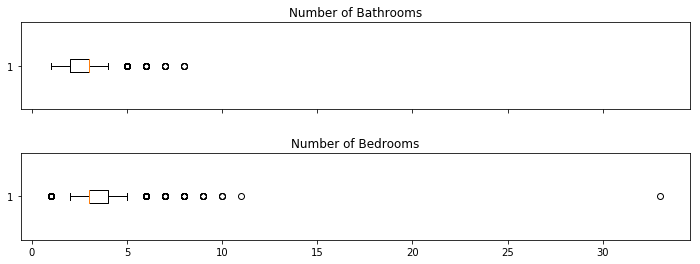

In [18]:
#boxplot bedrooms and bathrooms to check for outliers.
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,4), sharex=True)
ax1.boxplot(df.bathrooms, vert=False)
ax2.boxplot(df.bedrooms,vert=False)
ax1.set_title('Number of Bathrooms')
ax2.set_title('Number of Bedrooms')
plt.subplots_adjust(hspace=0.50)
plt.show()

From the boxplots above, 33 bedrooms is a very extreme outlier. Apart from this extreme outlier, there are other houses with 8 to 11 bedrooms that may have the need for 8 bathrooms. Hence, I will only focus in fixing the 33 bedroom value for now. I will start by comparing the number of bedrooms and bathrooms comparable houses have. I will compare this values from houses with similar sqft_living as the house with 33 bedrooms.

In [19]:
#Find out the size of the home with 33 bedrooms to see if it is possible that it can have that many.
print('Size: ',df[df['bedrooms']==33].sqft_living.values)
#Find out how many restrooms the home has.
print('Bathrooms: ',df[df['bedrooms']==33].bathrooms.values)
#Instead of dropping it I would like to see if there is a comparable home and see how many rooms it has.
print('Comparable houses (bedrooms): ',df[df['sqft_living'].between(1600,1650, inclusive=True)].bedrooms.describe())
print('Comparable houses (bathrooms): ',df[df['sqft_living'].between(1600,1650, inclusive=True)].bathrooms.describe())

Size:  [1620]
Bathrooms:  [2]
Comparable houses (bedrooms):  count    658.000000
mean       3.142857
std        1.287199
min        2.000000
25%        3.000000
50%        3.000000
75%        3.000000
max       33.000000
Name: bedrooms, dtype: float64
Comparable houses (bathrooms):  count    658.000000
mean       2.262918
std        0.703887
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: bathrooms, dtype: float64


Mean and median values for comparables homes, with similar sqft_living, are 3 bedrooms and 2 bathrooms. The house with 33 bedrooms has 2 bathrooms. Hence, I am inclined to beleive that the value of 33 bedrooms is most likely a typing error and should have been 3 bedrooms. I will proceed and replace the 33 value for a value of 3.

In [20]:
#Replace the 33 bedrooms for 3.
df.bedrooms.replace(33,3,inplace=True)

### 3.2  Is renovating your home worth it?
The variable 'id' is per home and each record is a transaction. Hence, an id can be repeated if a home has had more than one transaction, in other words, sold more than once. I will check to see how many duplicate id's are in the data set. I will then, compare the prices of homes with a transaction before and after the renovation. It is worth noting that since I do not have renovation budgets, I will not be able to answer if a renovation was profitable. Hower, the result from this analysis will tell us if there is a significat increase in price after a renovation has been performed.

In [21]:
print("Number of duplicated id's :", df.id.duplicated(keep=False).sum())
#Get data set with homes with at least two transactions
df_duplicates = df[df.id.duplicated(keep=False)][['id', 'price', 'yr_renovated', 'date']]
#Find out the transactions with renovations performed before being sold.
reno_df = df_duplicates[df_duplicates['yr_renovated']<df_duplicates['date'].dt.year]
#Remove non renovated units
reno_df = reno_df[reno_df['yr_renovated']>0]
print('Number of transactions for renovated homes: ',len(reno_df))
reno_df.head()

Number of duplicated id's : 353
Number of transactions for renovated homes:  8


,id,price,yr_renovated,date
324,7520000520,232000.0,1984,2014-09-05
325,7520000520,240500.0,1984,2015-03-11
717,8820903380,452000.0,1990,2014-07-28
718,8820903380,730000.0,1990,2015-01-02
3946,1825069031,550000.0,1980,2014-08-14


Since I could not find a single home with a transaction before and a transaction after a renovation, I loked for renovated houses with more than one transaction, but the sample is too small to create any insightful analysis to the data. Since some homes are as old as a century and it is very unlikely they have been in the market without any major renovations, there are probably missing yr_renovated values. Also, all of these homes were sold twice after the renovations, so a direct comparison between before and after renovation prices is not possible.<br>
I am changing the approach and comparing prices between homes sold with and without renovations.

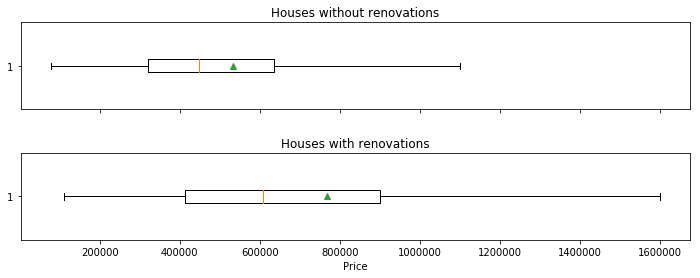

House prices without renovations median: $ 449000
House prices with renovations median: $ 607502
Percentage increase in price with renovations 35 %


In [22]:
#Create two sets of data, one for transactions without renovations (woreno) and one with renovations(reno).
prices_woreno = df[df['yr_renovated']== 0].price
prices_reno = df[df['yr_renovated']!= 0].price
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,4), sharex=True)
#Create boxplot without outliers for better visualization.
ax1.boxplot(prices_woreno, vert=False, showfliers=False, showmeans=True)
ax2.boxplot(prices_reno,vert=False, showfliers=False, showmeans=True)
ax1.set_title('Houses without renovations')
ax2.set_title('Houses with renovations')
plt.xlabel('Price')
plt.subplots_adjust(hspace=0.50)
plt.show()
print('House prices without renovations median: $',int(prices_woreno.median()))
print('House prices with renovations median: $',int(prices_reno.median()))
print('Percentage increase in price with renovations',
      int(float((prices_reno.median()-prices_woreno.median())/prices_woreno.median())*100),'%')

Houses without renovations sell for a meadian of 449,000.00 USD while houses with renovations sell for a median of  607,502.00 USD which repesents a 35% higher price. From this analysis, I conclude that **it is definitely worth renovating a home before selling it.** A better analysis could be achieved by collecting renovation budgets and having transaction records before and after the renovations.

### 3.3 What zip codes have seen the most price increase over time?
Zipcodes cluster houses int a designated geographical area. Certain zipcodes may include desirebale factors when looking for a home such as, proximity to good schools, parks, services, and recreational activities. Hence, zipcodes might be a significant factor when determining house prices. In this analysis, I will not be looking at pricing differences amongst zipcodes, but at what zipcodes have seen the most price increase of time. This will help uncover which zipcodes have experienced gentrification or a major development. 

In [23]:
#Get an array with unique zipcodes.
zipcodes = df.zipcode.astype(int).unique()
#Find out how many different zipcodes there are.
print('Number of unique zipcodes: ', zipcodes.shape[0])
#Get date of earliest transaction
print('Earliest transaction date: ',df.date.min())
#Get date of latest transaction
print('Latest transaction date: ',df.date.max())

Number of unique zipcodes:  70
Earliest transaction date:  2014-05-02 00:00:00
Latest transaction date:  2015-05-27 00:00:00


Teh data set has 70 different zipcodes and transactions over the course of 13 months starting on may 2014. Given this information, I will start by grouping the transactions in a per month basis to be able to compare the monthly average price changes amongst zipcodes over the course of a year.

In [24]:
df_months = df[['date','price','zipcode']].copy()
#normalize day to the beginning of month.
df_months['YearMonth'] = df_months['date'] + pd.offsets.MonthBegin(1)
df_months['YearMonth'] = df_months['date'].map(lambda dt: dt.replace(day=1))
df_months.drop('date',axis=1, inplace=True)
deltas_dict = {}
for zipcode in zipcodes:
    #Create temporary dataframe with transactions at a certain zipcode
    df_temp = df_months[df_months['zipcode']== zipcode].copy()
    #Get median value of the transactions per month. Median valueas are used to offset outlier effects.
    df_temp = df_temp.groupby('YearMonth').price.median()
    #Create a list to store month to month price changes.
    month_delta = []
    for i in range(len(df_temp)-1):
        #Calculate month to month change in median prices.
        delta = (df_temp[i+1]- df_temp[i])/df_temp[i]
        month_delta.append(delta)
    month_delta = np.array(month_delta)
    #Calculate monthly average price change as percentage.
    delta = round(month_delta.mean()*100,2)
    deltas_dict[zipcode] = delta
#Create dataframe 
df_deltas = pd.DataFrame.from_dict(deltas_dict,orient='index', columns=['m_delta'])
#Top 5 zipcodes.
print('The top 5 zipcodes are: ', list(df_deltas.sort_values('m_delta', axis=0, ascending=False).index[:5]))
print('m_delta = Mean percentage monthly change in price over the course of 13 months')
df_deltas.sort_values('m_delta', axis=0, ascending=False).head()

The top 5 zipcodes are:  [98024, 98014, 98112, 98006, 98022]
m_delta = Mean percentage monthly change in price over the course of 13 months


,m_delta
98024,9.83
98014,6.62
98112,6.43
98006,5.05
98022,4.81


From the table we get the top 5 zipcodes with the highest percentage price increase per month. I will proceed to plot the median house prices for each of the top 5 zipcodeas and the hole dataset, to compare and visualize what is happening to house prices over the course of the 13 months.

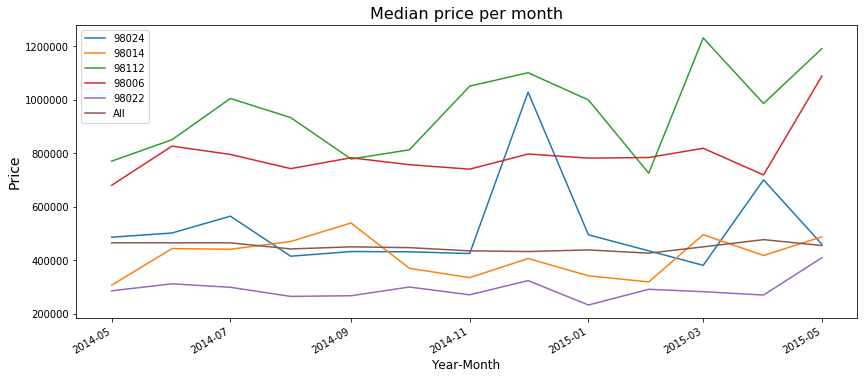

In [25]:
#Create list of top 5 zipcodes
top5_zip= list(df_deltas.sort_values('m_delta', axis=0, ascending=False).index[:5])
#Create figure 
fig = plt.figure(figsize=(14,6))
for zipcode in top5_zip:
    df_temp = df_months[df_months['zipcode']== zipcode].copy()
    df_temp = df_temp.groupby('YearMonth').price.median()
    df_temp.plot(label=zipcode, legend=True)
df_temp = df_months.groupby('YearMonth').price.median()
df_temp.plot(label='All', legend=True)
plt.title('Median price per month',fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Price', fontsize=14)
plt.show();

House prices remain quite stable overall. The median price of a home at the begining of the period is not much different from the final prices, resulting in no real returns. However, individual zipcodes appear to be more volatile through time. It is apparent that the high average monthly price increase on zipcode 98024 is due to a very high price increase on december 2015. On the other hand, all other values have a positive difference between their beginning and ending values. Zipcodes 98112 and 98006 apart from having high average price increases per month, they also show a high increse from their begining values.
On a side note, I notice that zipcodes have somewhat defined price floors and ceilings, meaning houses from the same zipcode share similar characteristics amongst each other.

### 3.4  Does having a higher grade translate to a higer price?
I assume that any given person would be willing to pay a premium to buy a better quality home. The process of comparing house quality has been facilitated by King County by issuing a rubric provided to efficiently assign a grade to a house. This rubric enhances objectivity and makes the grade a better predictor than condition. I will compare median prices amongst grades by grouping them and cerating bozplots to visualizes the pricing differences.

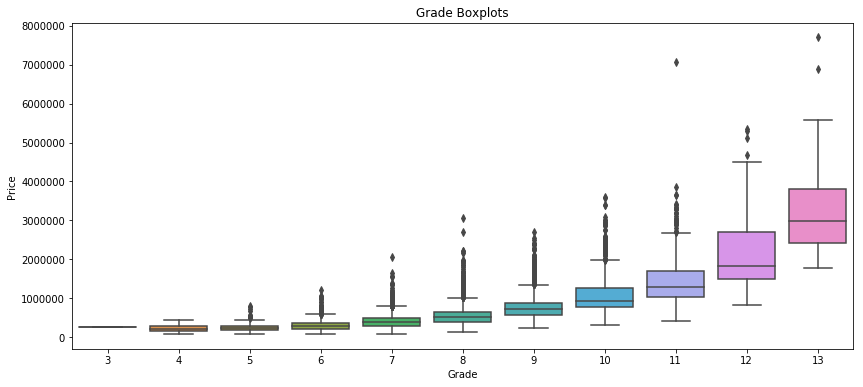

In [26]:
#Create a subset of the database with the variables needed for the analysis.
plt.figure(figsize=(14, 6))
sns.boxplot(x='grade', y='price', data=df)
plt.title('Grade Boxplots')
plt.ylabel('Price')
plt.xlabel('Grade')
plt.show()

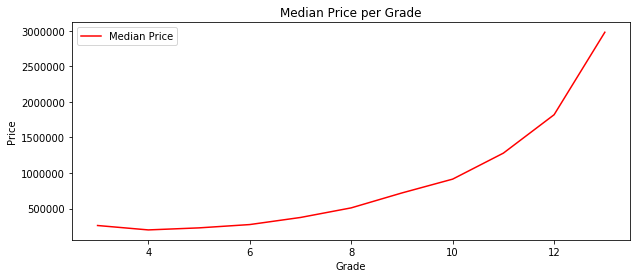

In [27]:
#Create a line plot to visualize the median price for each grade.
df_grade=df[['grade','price']].groupby('grade').median().copy()
df_grade.reset_index(inplace=True)
plt.figure(figsize=(10, 4))
sns.lineplot(x='grade', y='price', color='red',data=df_grade, label='Median Price')
plt.ylabel('Price')
plt.xlabel('Grade')
plt.title('Median Price per Grade')
plt.show()

From the boxplots I gather there is not much difference amongts the first half of the grades. As the grades go up, so does median house prices. This could be a result of people paying premium dollars to have the houses with the highest grade possible, a grade of 12 or 13. In regards to the lineplot, it furthers my observations, with median prices increasing exponentially as grades increase. Grades, should be a categorical data type, I will proceed and correct its datatype.

In [28]:
df['grade'] = df['grade'].astype('category')
df['grade'].dtype

CategoricalDtype(categories=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ordered=False)

### 3.5 Preprocessing
During this stage I will plot their histograms and kernel density functions to test for normality for numerical variables.

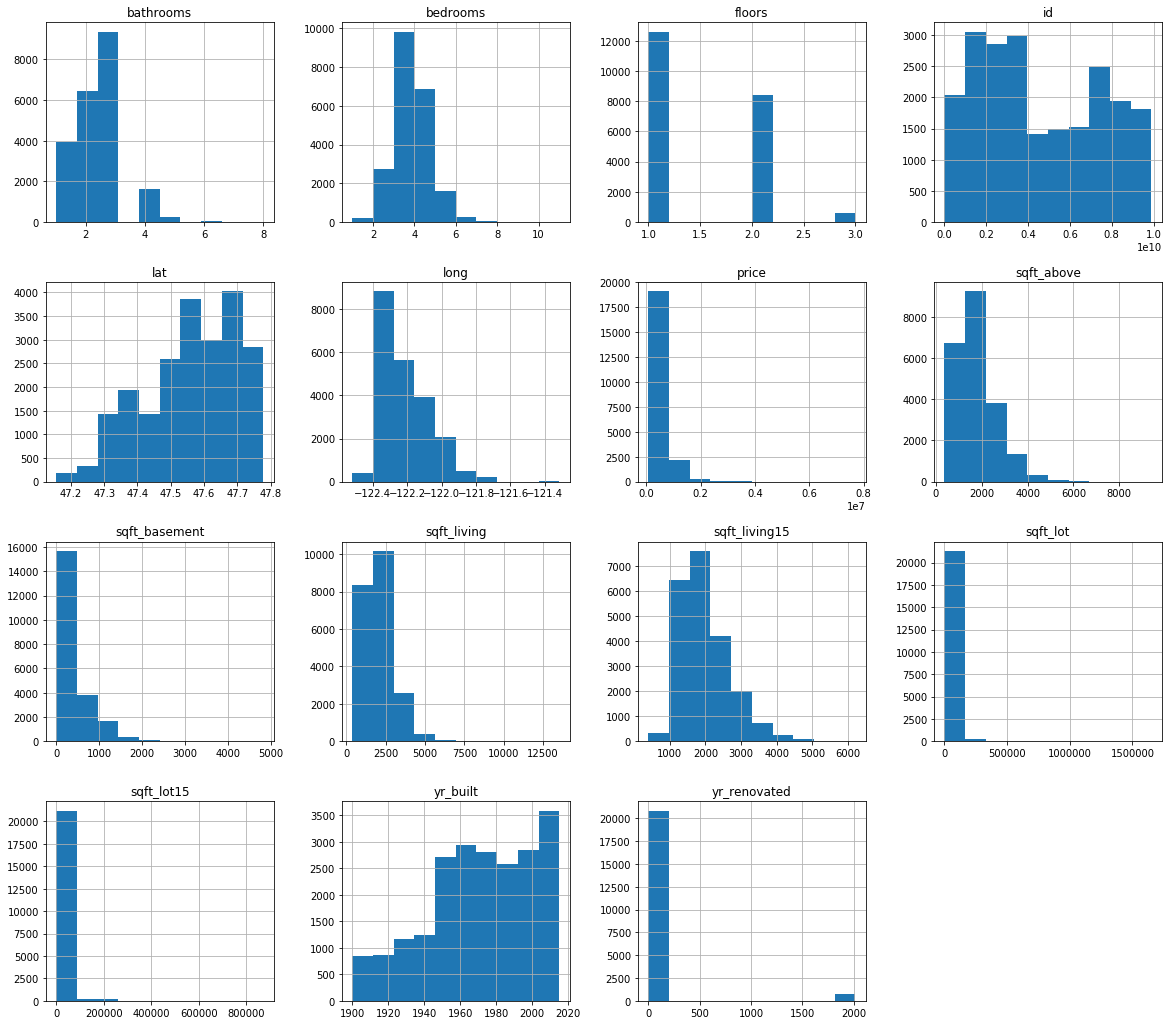

In [29]:
#Plot a histogram to visualize the numeric variable's distributions
df.hist(figsize = (20,18));

**Observations on distributions:**
* Price is leptokurtic and heavily positively skewed.
* Bathrooms, bedrooms, and floors are non continuous variables.
* longitude and all square footage variables might 
* yr_renovated and sqft_basement have several 0 values.
* id is irrelevant to the project
* Most variables have outliers and break the normality assumption.<br>

Teh sqft_lot15 histogram appeared as if it had moslty '0' values. It is very likely that extreme outliers may make the histogram visualization almos impossible. Hence, I will look into its descriptive statistics to make sure the values are not just 0 and that I have enough menaingful information in it.

In [30]:
df.sqft_lot15.describe()

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

It's great to see that sqftlot_15 does not have '0' values and that the histogram was being havily influenced by an extreme outlier. I will now proceed to look into the continuous variables probability densities and KDEs.

/Users/feraguilari/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


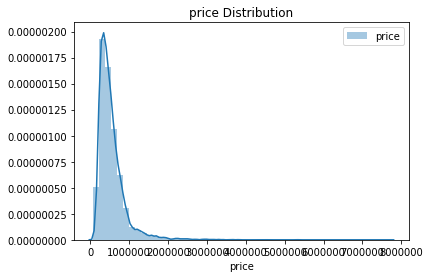

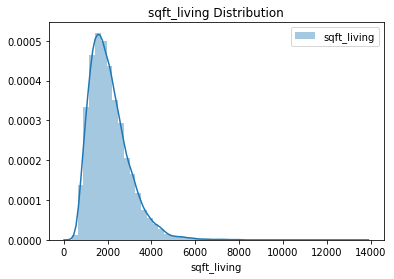

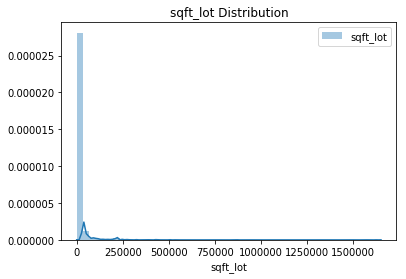

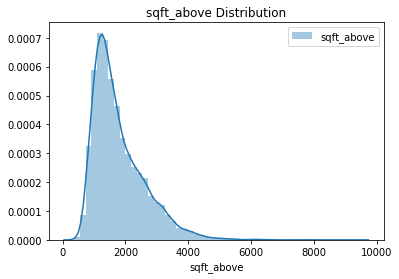

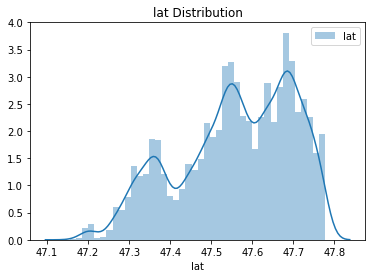

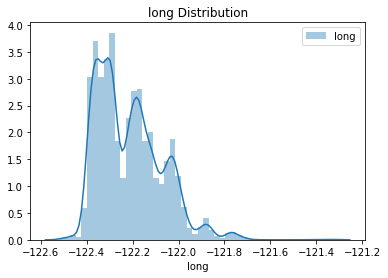

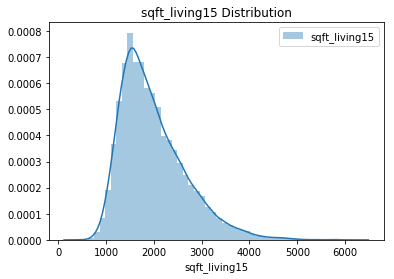

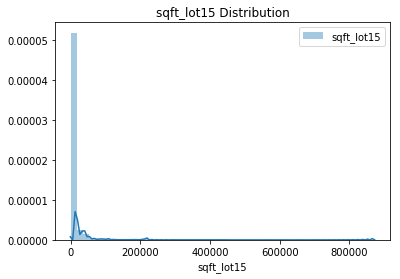

In [31]:
#Create list of continuos variables
cont_var = ['price', 'sqft_living', 'sqft_lot','sqft_above', 'lat','long', 'sqft_living15', 'sqft_lot15']
def plot_histkde(data, columns):
    for column in columns:
        sns.distplot(data[column], label=column)
        plt.title (column + ' Distribution')
        plt.legend()
        plt.show()
plot_histkde(df, cont_var)

**Observations:**
* The distributions show heavy positive skeweness, except: lat.
* Some distributions appear to be multimodal.
* sqft_lot and sqft_lot15 have extreme outliers to the right.<br>

**Next steps:**
Based on the observations, I will apply the following solutions:
1. Delete extereme outliers for sqft_lot and sqft_lot15
2. Covert sqft_basement and yr_renovated into binary category types
3. For positively skewed data: apply log transformation
4. For lat and long: apply cube root and square transformation accordingly.


#### 3.5.1 Delete extreme outliers for sqft_lot and sqft_lot15

Records above 150,000 sqft_lot:  331


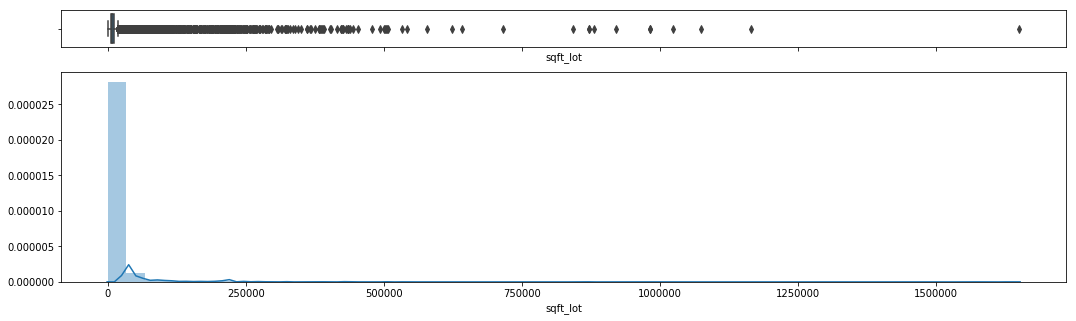

In [32]:
def box_distplot(variable):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(18,5),)
    sns.boxplot(variable, ax=ax_box)
    sns.distplot(variable, ax=ax_hist)
box_distplot(df.sqft_lot)
print('Records above 150,000 sqft_lot: ',len(df[df['sqft_lot']>150000]))

From the plot above, I beleive a good cutoff point would be 200,000 sqft. since only 331 records from our data contain such large lots. Before deleting the records let's look at how the distribution will look like after I delete the outliers.

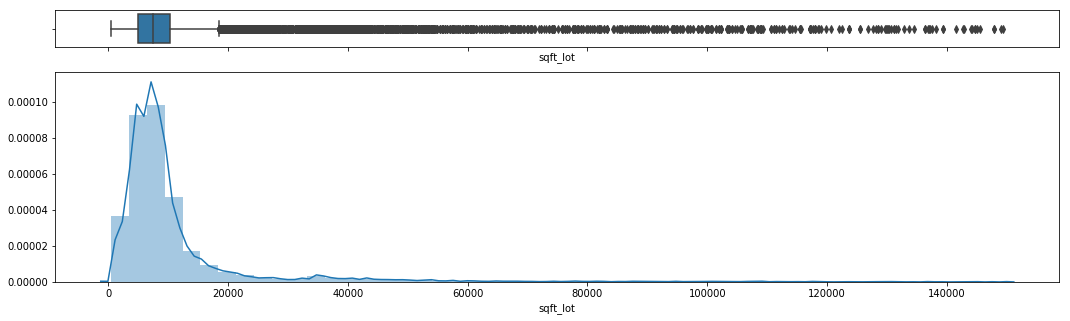

In [33]:
box_distplot(df[df['sqft_lot']<150000].sqft_lot)

Although the varibale is still not normally distributed without the outliers, it is definitely an improvement. Since the distribution looks more lognormally distributed, I will transform it at a later stage. After deleting the utliers, I will do the same process to sqft_lot15.

In [34]:
#Delete records containing sqft_lot>150000
df=df[df['sqft_lot']<150000]

Records above 120,000 sqft_lot15:  75


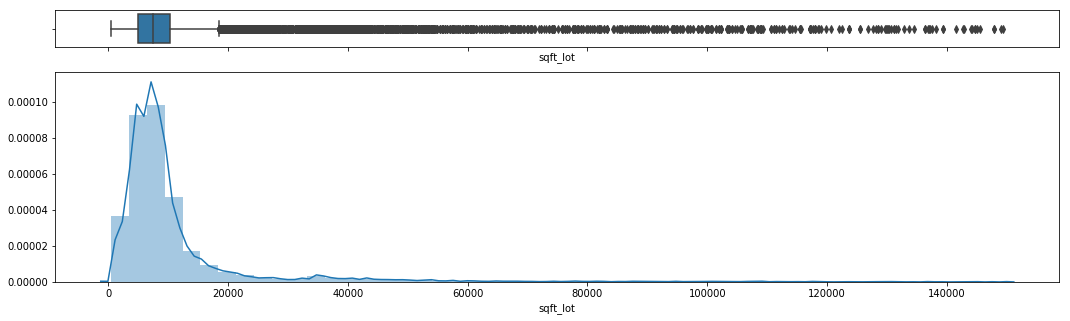

In [35]:
print('Records above 120,000 sqft_lot15: ',len(df[df['sqft_lot15']>120000]))
box_distplot(df.sqft_lot)

In [36]:
#A good cutoff point would be 120,000 with only 75 records above the cutoff point.
df=df[df['sqft_lot15']<120000]

#### 3.5.2 Covert sqft_basement and yr_renovated into binary category types

From previous EDA, it was noticeable that most values in this variables where 0s. Hence, a better approach is to onehot code them and treat them as categorical variables.

In [37]:
#Convert sqft_basement to binary variable.
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 1 if (x>0) else 0).astype('category')
#Convert yr_renovated to binary variable.
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if (x>0) else 0).astype('category')

At this point and before any transformations, I will proceed to save my new partially preprocessed and clean dataset. This will enable me to come back to the raw data in case it is needed later on. 

In [38]:
df.to_csv('KingsCounty_Clean.csv')
#Create new dataframe for transformations
df_trans = df.copy()

#### 3.5.3 Apply log transformation for positively skewed data

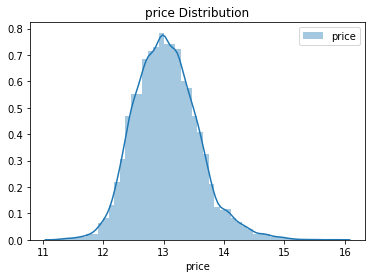

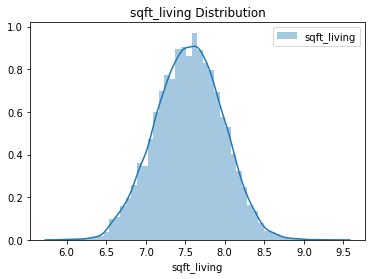

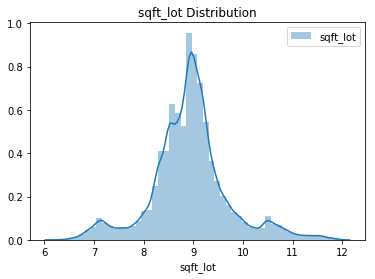

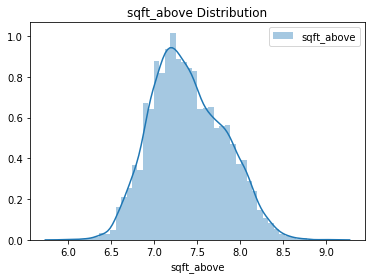

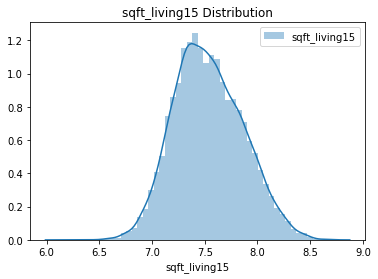

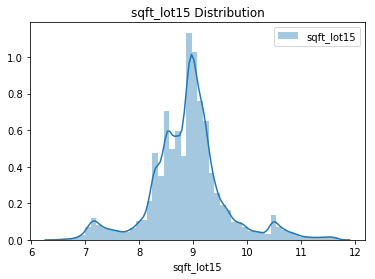

In [39]:
#Not including long, since it has negative values.
trans_log = ['price', 'sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15']
for col in trans_log:
    df_trans[col]=np.log(df[col])
plot_histkde(df_trans, trans_log)

All variables improved their distributions as they became more normally distributed.
### 3.5.4 Apply Cube Root and Square Transformation to lat and long accordingly.

From the initial distribution explotarion, I noticed that long and lat did not follow eather a normal nor a lognormal distribution. Moreover, long is entirely composed of negative values. I will then proceed to perfom cube root transformation to lat, expecting to improve its distribution, and square transformation to long.

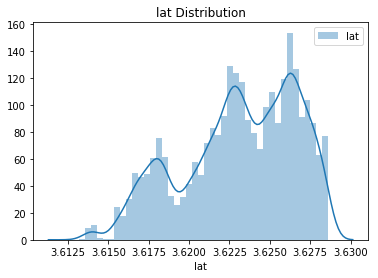

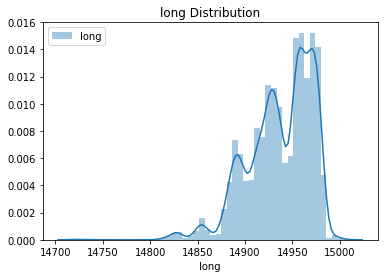

In [40]:
#Cubre root transfor lat
df_trans['lat']=np.power(df['lat'],(1/3))
#Square transformation for long
df_trans['long']=np.power(df['long'],2)
trans_list = ['lat','long']
plot_histkde(df_trans, trans_list)

Neither variable improve much, I might have to drop them after testing for multicolinearity. I find lat and long might have been more useful if we had the same information for important landmarks such as public parks, schools, banks, services, etc. and calculate the distance from the home to each of them. The distances to this interest points might be an important factor in predicting price.

### 3.6 Test for linearity assumption
For this stage I'm going to plot the relevant variables for our model to test for linearity. I will begin by dropping the following variables:
* 'id' is not random and does not provide relevant information for our model, and
* 'date' I will not be performing time series analysis<br>

I will temporarily transform categorical variables to an uint8 datatype to be able to plot them.

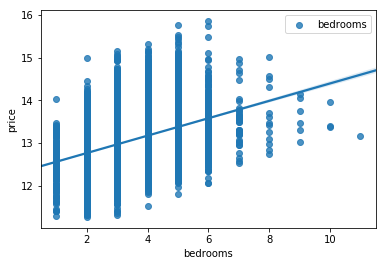

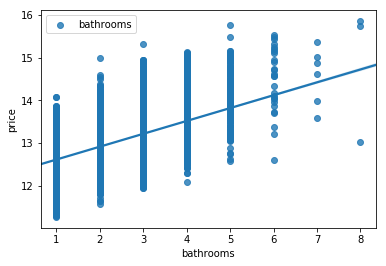

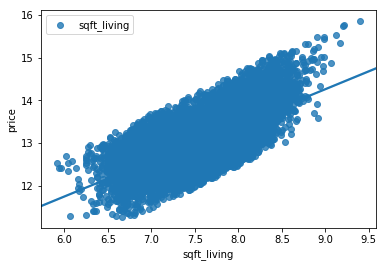

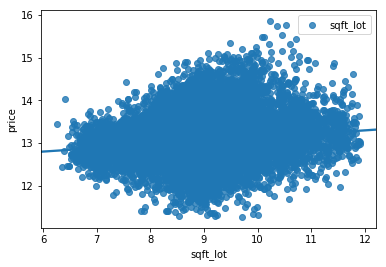

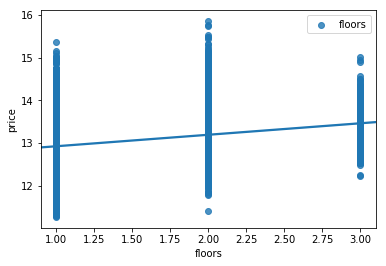

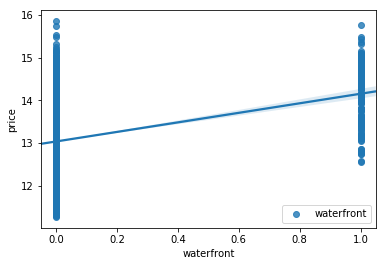

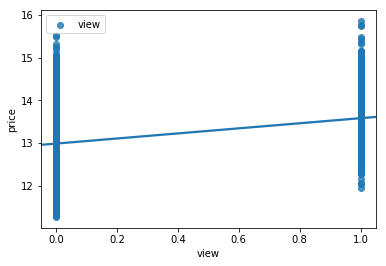

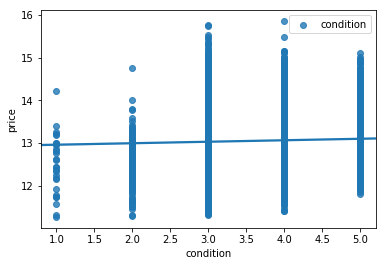

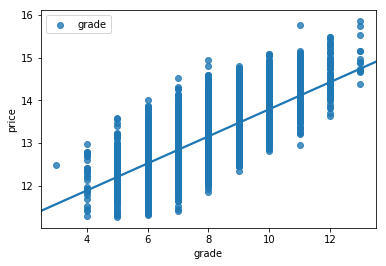

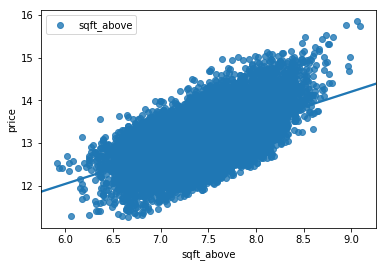

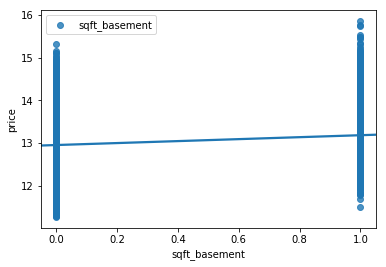

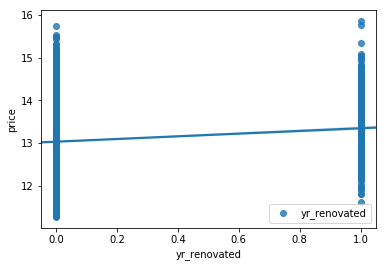

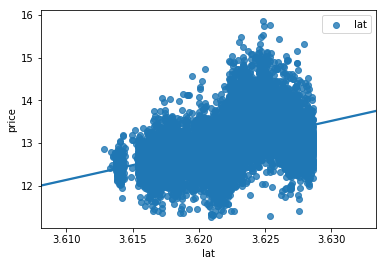

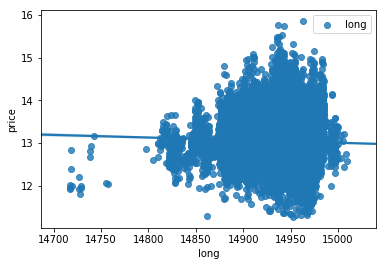

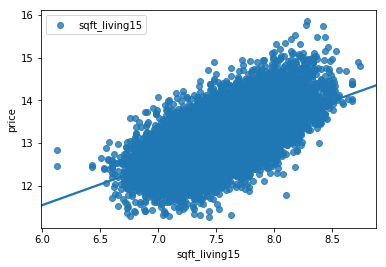

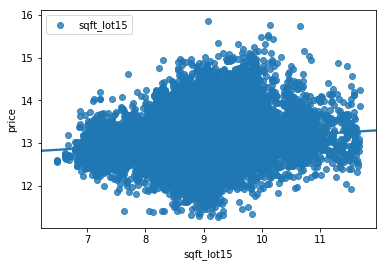

In [41]:
df_trans.drop(['id','date'], axis=1, inplace=True)
#Get categoric variables
cat_var = df_trans.select_dtypes('category').columns
for col in cat_var:
    df_trans[col] = df_trans[col].astype('uint8')
#Create a regplot to test for linearity.
#Drop zipcode for being an unordered discrete variable.
for col in df_trans.columns.drop(['price','zipcode','yr_built']):
    sns.regplot(df_trans[col], df_trans.price, label=col)
    plt.legend()
    plt.show()

Most variables appear to have a linear relationship to price of some degree and appear to be homoscedastic, except: sqft_lot, floors, condition, yr_built, lot, and sqft_lot15. I will have this variables in mind while perfoming the multicolinearity test.

### 3.6 Multicolinearity
During this stage I will plot a correlation matrix and a correlation heatmap to start filtering out features in preparation to develop a price predictive model. Milticolinearity happens when two or more of the features in a multiple regression model are highly corralated. This is undesirable since. For the purpose of this project I will define two features as being highly correlated if their correlations has an absolute value of 0.75.<br>

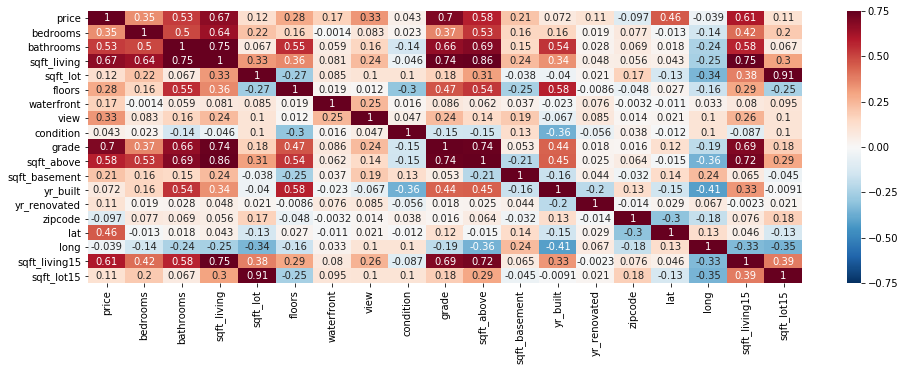

In [42]:
correlation = df_trans.corr()
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-0.75, vmax=0.75, cmap="RdBu_r")

From the correlation matrix above, observations during the EDA, and the normality and lineraity tests, I will keep the following features to build the predictive model:
* sqft_living
* yr_renovated
* zipcode
* lat
* grade

### 3.7 Scaling the data finish pre processing.
Before proceeding to the modelling stage. I will scale the data using minmax scaling for all non categorical variables.

In [43]:
#Revert variables to categorical.
for var in ['waterfront','view','condition','grade','sqft_basement','yr_renovated','zipcode',
            'yr_built', 'bedrooms', 'floors', 'bathrooms']:
    df_trans[var]=df[var].astype('category')

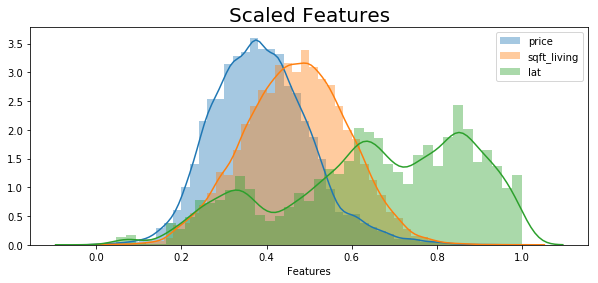

In [44]:
#Get final data set
df_final = df_trans[['price','sqft_living','lat', 'yr_renovated', 'zipcode', 'grade']].copy()
#Scale and plot continuous variables with minmax
plt.figure(figsize=(10,4))
for var in ['price','sqft_living','lat']:
    df_final[var] = df_final[var].apply(lambda x:  (x-df_final[var].min())/(df_final[var].max()-df_final[var].min()))
    sns.distplot(df_final[var], label=var)
plt.title('Scaled Features', fontdict={'fontsize': 20})
plt.xlabel('Features')
plt.legend()
plt.show()

Now that the continuous random variables and the target have been scaled, I will proceed to create the dummy variables for the categorical variables.

In [45]:
#Make dummies of categorical values and add them to the final dataframe
for col in df_final.select_dtypes('category').columns:
    #Create dummies
    col = pd.get_dummies(df_final[col], prefix=col, drop_first=True)
    #Join to final dataframe
    df_final = df_final.join(col)
#Delete categorical variables
for col in df_final.select_dtypes('category').columns:
    df_final.drop(col, axis=1, inplace=True)

## 4. Multiple Linear Regression
For this stage I will build a model taking into account the features previously selected ('sqft_living', 'lat', 'yr_renovated', 'zipcode', 'grade') and test their significance in predicting our target variable ('price). I will first build a model including all of the features selected and look at it's R-squared. I will compare the R-squared obtained to the following model built using recursive feature elimination (RFE).

In [46]:
#Define target 'y'(dependendent variable) and features 'X'(independent variables or predictors).
y = df_final['price']
X = df_final.drop('price',axis=1)
#Test each continus variable as a standalone linear regression.
col_names = X.select_dtypes('float').columns
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Selling price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = smf.ols(formula=f, data=df_final).fit()
    X_new = pd.DataFrame({val: [X[val].min(), X[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    print(results[idx+1])

Selling price~sqft_living
------------------------------
['sqft_living', 0.4504851147267033, 0.08962350080510796, 0.6358764251985838, 0.0]
Selling price~lat
------------------------------
['lat', 0.21112253075290077, 0.2318977649531629, 0.23819279894216772, 0.0]


R_squared values are less than ideal, however p-values approximate 0, wich is great. Given the low correlation between this two independent variables, I expect that by including both variables, the r_squared value will increase without increasing p-values. Now, I will run the same test for each of the categorical variables.

In [47]:
#Separating all dummy variables into their own categories.
cols_yreno = [col for col in X.columns if 'yr_renovated' in col]
cols_zipcode = [col for col in X.columns if 'zipcode' in col]
cols_grade = [col for col in X.columns if 'grade' in col]
cols=[cols_yreno,cols_zipcode,cols_grade]

for col in cols:
    sum_cols = "+".join(col)
    f = "price ~" + sum_cols
    model = smf.ols(formula= f, data= df_final).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     255.5
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           3.51e-57
Time:                        10:42:28   Log-Likelihood:                 15958.
No. Observations:               21191   AIC:                        -3.191e+04
Df Residuals:                   21189   BIC:                        -3.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3851      0.001    483.

Out of the 3 categorical variables selected, yr_renovated had the lowest R_squared value. Hence, I will delete it from the model moving forward. Once deleted, I will proceed with the multivariate model.

In [48]:
#Delete yr_renovated
X.drop(cols_yreno, axis=1, inplace=True)

I will run a linear regression with the remaining variables. I will be using a train test split to avoid overfitting the model to the given dataset. I will then compare RMSE amongst trainning and testing values to better evaluate the fit of the model.

In [49]:
#Define function for linear regression
linreg = LinearRegression()
def lin_reg(X, y):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    linreg.fit(X_train, y_train)
    y_hat = linreg.predict(X_test)
    y_hat_train = linreg.predict(X_train)
    print('R_squared Score:', linreg.score(X, y))
    #Display errors
    print('Mean Absolute Error:', mas(y_test, y_hat))
    print('Root Mean Squared Error test:', np.sqrt(mse(y_test, y_hat)))
    print('Root Mean Squared Error train:', np.sqrt(mse(y_train, y_hat_train)))
    #Compare predicted and actual values
    print('Mean Predicted Selling Price:', y_hat.mean())
    print('Mean Selling Price:', y_test.mean())
    return linreg
lin_reg(X,y)

R_squared Score: 0.8509170798508066
Mean Absolute Error: 0.03276086786464242
Root Mean Squared Error test: 0.04548436995621095
Root Mean Squared Error train: 0.04384791011798463
Mean Predicted Selling Price: 0.38745832164362815
Mean Selling Price: 0.38768714889019446


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### 4.1 Model Validation
The R_squared score obtained from running a model utilizing all of our features and dummy variables is high at 85%.Moreover, Mean predicted and actual selling prices are somewhat similar and RMSEs amongst trainning and testing subsets is very small. I would consider it a good fit overall, however the high R squared value could be a result of including a large number of variables. To further explore this issue, let's validate our model using a 5-fold cross-validation . 

In [50]:
def cross_validation(X, y):
    score = cross_val_score(linreg, X, y,cv=5, scoring="r2")
    print('R_squared Mean Score:',score.mean())
    print(score)
cross_validation(X,y)

R_squared Mean Score: -6.44414675982732e+18
[-3.22207338e+19  8.47272164e-01  8.42818063e-01  8.52439254e-01
  8.53224924e-01]


The cross-validation result is negative. Therefore, either the intercept or the slope are constrained so that the line of best fit, fits worse than a horizontal line. This confirms the observation that the initial model might be overfitted. I will crete a new model using feature selection to remove features that are causing noice in my inital model. 

In [51]:
### 4.2 Feature selection using recursive feature elimination.
estimator = SVR(kernel="linear")
#Use RFE to remove not significant features from the initial model.
selector = RFE(estimator, step=1)
selector = selector.fit(X, y)

In [52]:
#Test new model
#New features dataframe containing only selected features through RFE
X_RFE = X[X.columns[selector.support_]]
lin_reg(X_RFE, y)

R_squared Score: 0.826920378832534
Mean Absolute Error: 0.03616346690468878
Root Mean Squared Error test: 0.0486670535970672
Root Mean Squared Error train: 0.04736273025515956
Mean Predicted Selling Price: 0.3874946210242774
Mean Selling Price: 0.3880449550610035


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

By eliminating certain fetaures, the R squared value actually dropped to nearly 83% (from 85%). However, I am happy that differences amogst RMSEs still remain very low and Mean prices also remained very similar. I hope to see a better cross validation result. This would further support the strength of this new model.

In [53]:
cross_validation(X_RFE,y)

R_squared Mean Score: 0.8244926988540975
[0.82332196 0.82025237 0.81959714 0.82832553 0.8309665 ]


The mean R squared obtained form the 5-fold cross_validation is a positive 82%. Hence, this model does a much better job than the first one. I will now proceed to look for any features that have a p-value > 0.05, and delete them from the model.

In [54]:
def OLS_reg(X):
    for col in [X.columns]:
        all_cols = "+".join(col)
    f = "price ~" + all_cols
    #print(f)
    model = smf.ols(formula= f, data= df_final).fit()
    print(model.summary())
    return model
OLS_reg(X_RFE)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     2530.
Date:                Mon, 15 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:43:40   Log-Likelihood:                 34429.
No. Observations:               21191   AIC:                        -6.878e+04
Df Residuals:                   21150   BIC:                        -6.845e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1126      0.003     39.820

From using the RFE we managed to keep both continuous varibles and drop most dummy variables. Although, R_squared decresed from 85% to 83% the model is more robust with a positive cross-validation result. Also, there are no features with p-value>0.05, therefore I can reject the null hypothesis that the features are not significant in predicting price values.

## 5. Conclusion

I managed to build a multivariate predictive model with an R_squared of nearly 83%. All of the fetures have p-values<0.05, the overall, RMSEs are fairly small and the difference amongst training and testing RMSEs is almost negligible.  The most significant variables from our data set were zipcode, latitude, sqft_living, and grade.